## ANLP Final Project

Sai Shruthi Umakanth & Gayatree Tiwari
12th December, 2018

In [127]:
%matplotlib inline

import re
import gensim
import nltk
import spacy
import math
import langid
import numpy as np
import pandas as pd
import en_core_web_sm
import string as string
from pprint import pprint
nlp = en_core_web_sm.load()
#nltk.download('stopwords')
from langdetect import detect
from nltk.stem.porter import *
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim import corpora, models
from nltk.stem import PorterStemmer
# from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from porter2stemmer import Porter2Stemmer
from nltk.tokenize import RegexpTokenizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
# https://github.com/saffsd/langid.py


In [2]:
songs = pd.read_csv(r"C:\Users\e9900331\Documents\IUB\Fall 2018\L 645\Final Project\lyrics.csv")


In [3]:
print(songs.shape)

(362237, 6)


In [4]:
#creating vector with stopword
stop_words = set(stopwords.words('english'))
print(stop_words)
# for word in stop_words:
#     print(word)

{"you'd", 'couldn', 'that', 'to', 'being', 'same', "doesn't", 'then', 'hasn', 'we', 'if', 'does', 'for', 'my', 'she', "weren't", 'whom', 'too', 'some', 'or', 'a', 'only', 'further', 'you', 'so', "mustn't", 'our', 'there', 'doing', 'mightn', 'has', 'over', 'all', 'those', 'such', "wouldn't", 'hadn', 'of', 'nor', 'while', 're', 'where', 'than', "hasn't", 'haven', 'after', 'him', 'into', "that'll", 'did', 'how', 'myself', 'under', 'ain', 'shan', 'their', 'out', 'below', 'from', 'be', 'because', 'by', 'more', "shouldn't", 'up', 'off', 'any', 'few', 'at', 'didn', 'themselves', 'wasn', 'in', 'me', 'very', 'once', 'theirs', "haven't", 'on', 'when', 'her', 'herself', 'which', 'have', "should've", 'having', "she's", "aren't", 'won', 'yourself', 'been', 'now', 'himself', "you're", 'itself', 'the', 'just', 'why', 'most', 'above', 'who', 'o', 'hers', 'not', "hadn't", 'weren', "needn't", 'its', "won't", 'here', "you've", 'yours', 'can', 'd', "couldn't", 'shouldn', 'is', 'm', 'was', 'wouldn', 'doesn

In [5]:
def replace_stopwords(text):
    words = nltk.word_tokenize(str(text))
    song = [word for word in words if(word not in stop_words)]
    return (" ".join(song))

# Ref: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python

exclude = set(string.punctuation)
regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(s): 
    return regex.sub('', str(s))

# def remove_short_songs(s):
#     if(len(str(s)) > 20): return s
    
# Ref: https://stackoverflow.com/questions/26264579/select-the-rows-that-satisfy-the-same-condition-on-all-columns
def select(list_of_rows, filter_function):
    result = []
    for row in list_of_rows:
        if filter_function(row):
            result.append(row)
    return result

def str_filter(s):
    if (isinstance(s, str)):
        return True
    return False

def not_short(s):
    if (len(str(s)) > 150):
        return True
    return False

def is_English(s):
    if(detect(s) == 'en'):
        return True
    return False

# def get_alpha(s):
#     if(s.isalpha()):
#         return True
#     return False

In [6]:
#clean data
songs = songs[0:10000]
songs.lyrics = songs.lyrics.str.lower()
songs.lyrics = songs.lyrics.str.replace('[^\w\s]','')
songs.lyrics = songs.lyrics.str.replace('\d+', '')
print("BEFORE: ",songs.lyrics.head())
songs.lyrics = songs.lyrics.str.replace('\n', ' ')
# print("AFTER: ",songs.lyrics.head())
songs.lyrics = songs.lyrics.map(replace_stopwords)
# print("GET....RID@@ of this. ??")
# print("Punctuation removed: ")
# print(remove_punct("GET....RID@@ of this. ??"))

# songs.lyrics = songs.lyrics.str.strip()
# songs.lyrics = songs.lyrics.dropna().apply(lambda x: [item for item in x if item not in stop_words])
# print("AFTER removing stopwords: ",songs.lyrics.head())

BEFORE:  0    oh baby how you doing\nyou know im gonna cut r...
1    playin everything so easy\nits like you seem s...
2    if you search\nfor tenderness\nit isnt hard to...
3    oh oh oh i oh oh oh i\nverse \nif i wrote a bo...
4    party the people the people the party its popp...
Name: lyrics, dtype: object


In [7]:
songs.lyrics = songs.lyrics.dropna()
songs.lyrics = songs.lyrics.str.strip()

# Filter out NANs, and all other values which are not strings: 

print("length before filtering out NaNs: ",len(songs))
songs = pd.DataFrame({'lyrics':select(songs.lyrics, str_filter)})
print("length after filtering out NaNs: ",len(songs))
songs = pd.DataFrame({'lyrics':select(songs.lyrics, not_short)})
print("length after filtering out short ones (<150 chars): ",len(songs))


length before filtering out NaNs:  10000
length after filtering out NaNs:  10000
length after filtering out short ones (<150 chars):  6545


In [119]:
# Ref: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
# nltk.download('all')
# stemmer = Porter2Stemmer()
ps = PorterStemmer()
wl=WordNetLemmatizer()
# snowball=SnowballStemmer("english")
ar1 = []
songs_stemmed = []
def process_song(text):
    stemmed_song = []
    for token in nltk.word_tokenize(str(text)):
        if len(token) > 2:
            stemmed_song.append(ps.stem(token))
    return stemmed_song

# temp_song_lyrics = ' '.join(ar1)
processed_songs = [process_song(song) for song in songs.lyrics]
processed_songs[:2]

# Bag of words: 
dictionary = gensim.corpora.Dictionary(processed_songs)
count = 0
print("Sneak Peek at the dictionary: ")
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 5:
        break
print("Size of dictionary: ")
print(len(dictionary))

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=5000)
print("Size of dictionary after filtering for most frequent words: ")
print(len(dictionary))


Sneak Peek at the dictionary: 
0 admit
1 aint
2 arrog
3 babi
4 back
5 beat
Size of dictionary: 
40886
Size of dictionary after filtering for most frequent words: 
3401


In [122]:
# Calculating how many words and their frequency of occurence: 
song_corpus = [dictionary.doc2bow(song) for song in processed_songs]
song_corpus[1]
print("Length of song corpus: ")
print(len(song_corpus))
song_xyz = song_corpus[1]

for i in range(len(song_xyz)):
    print("Word {} (\"{}\") appears {} times.".format(song_xyz[i][0],
                                                     dictionary[song_xyz[i][0]],
                                                     song_xyz[i][1]))


Length of song corpus: 
6545
[(3, 1), (24, 1), (25, 3), (27, 1), (30, 4), (34, 2), (42, 4), (43, 2), (45, 5), (47, 3), (63, 1), (65, 1), (70, 2), (76, 1), (80, 7), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 4), (96, 1), (97, 1), (98, 2), (99, 1), (100, 2), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1), (111, 1), (112, 1), (113, 1), (114, 1), (115, 1), (116, 1), (117, 2), (118, 3), (119, 6), (120, 1), (121, 1), (122, 1), (123, 1), (124, 1), (125, 2), (126, 1), (127, 2), (128, 3), (129, 1), (130, 2), (131, 4), (132, 3), (133, 1), (134, 1), (135, 4), (136, 4), (137, 2), (138, 1), (139, 1)]
Word 3 ("back") appears 1 times.
Word 24 ("didnt") appears 1 times.
Word 25 ("dont") appears 3 times.
Word 27 ("everi") appears 1 times.
Word 30 ("feel") appears 4 times.
Word 34 ("gon") appears 2 times.
Word 42 ("know") appears 4 times.
Word 43 ("leav") appears 2 times.
Word 45 ("let") appears 5 times.
Word 47 ("like") appear

In [11]:
# ------------------------------------------------------------
# TF-IDF 

tfidf = models.TfidfModel(song_corpus)
corpus_tfidf = tfidf[song_corpus]

for song in corpus_tfidf:
    pprint(song)
    break


[(0, 0.05296714288504844),
 (1, 0.04002070823376219),
 (2, 0.04090911159530849),
 (3, 0.16720980260251078),
 (4, 0.03130283414154525),
 (5, 0.024490322599041357),
 (6, 0.3408789777773468),
 (7, 0.029492357061474312),
 (8, 0.03090493807007326),
 (9, 0.03004613825720703),
 (10, 0.04959770535339817),
 (11, 0.026151938799291136),
 (12, 0.05929306280795333),
 (13, 0.16305463464610326),
 (14, 0.04353080364904444),
 (15, 0.044352597117816826),
 (16, 0.058177721156181306),
 (17, 0.06484387218783935),
 (18, 0.019317430193188784),
 (19, 0.04803410094415967),
 (20, 0.03438979172149682),
 (21, 0.033022294553373084),
 (22, 0.04220616279652171),
 (23, 0.05236160731313609),
 (24, 0.030932886711905846),
 (25, 0.03024410932759973),
 (26, 0.7516432691414957),
 (27, 0.020347154703454075),
 (28, 0.017119348436680067),
 (29, 0.03989337917887349),
 (30, 0.042481811767185636),
 (31, 0.02103060367592138),
 (32, 0.12457701129532313),
 (33, 0.012010283320752107),
 (34, 0.03922670513135025),
 (35, 0.062982796556

In [150]:
# Running LDA using bag of words:
lda_model = gensim.models.LdaMulticore(song_corpus, num_topics=10, id2word=dictionary, passes=2, workers=4)
# print(set(songs.genre))
# Words for each topic and occurence: 
# print(lda_model.print_topics(-1))


[(0, '0.017*"like" + 0.016*"know" + 0.014*"get" + 0.014*"time" + 0.012*"away" + 0.011*"dont" + 0.011*"never" + 0.010*"see" + 0.009*"way" + 0.009*"take"'), (1, '0.016*"know" + 0.014*"time" + 0.012*"wan" + 0.012*"love" + 0.010*"like" + 0.010*"dont" + 0.010*"girl" + 0.010*"got" + 0.009*"come" + 0.009*"day"'), (2, '0.022*"dont" + 0.014*"like" + 0.013*"see" + 0.013*"nigga" + 0.013*"get" + 0.011*"know" + 0.010*"back" + 0.008*"aint" + 0.007*"caus" + 0.007*"take"'), (3, '0.021*"got" + 0.018*"like" + 0.015*"get" + 0.014*"dont" + 0.014*"want" + 0.010*"know" + 0.009*"one" + 0.009*"nigga" + 0.008*"let" + 0.008*"come"'), (4, '0.012*"dont" + 0.012*"let" + 0.012*"love" + 0.012*"babi" + 0.010*"like" + 0.010*"make" + 0.009*"get" + 0.009*"never" + 0.008*"know" + 0.008*"hey"'), (5, '0.025*"que" + 0.017*"know" + 0.012*"ill" + 0.012*"dont" + 0.011*"like" + 0.011*"love" + 0.009*"think" + 0.008*"cant" + 0.008*"get" + 0.008*"take"'), (6, '0.013*"time" + 0.012*"one" + 0.011*"your" + 0.011*"come" + 0.009*"see" 

Song to be tested: 


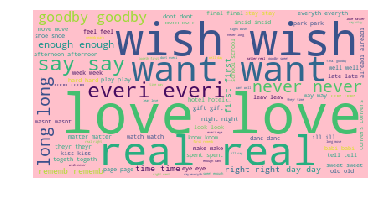

In [153]:
# Classifying sample song using our LDA model:
print("Song to be tested: ")
song_xyz=song_corpus[100]
# for i in range(len(song_xyz)):
#     print("Word {} (\"{}\") appears {} times.".format(song_xyz[i][0],
#                                                      dictionary[song_xyz[i][0]],
#                                                      song_xyz[i][1]))
# Ref: https://gist.github.com/tokestermw/3588e6fbbb2f03f89798

# multiplier=1000
def terms_to_wordcounts(terms, multiplier=2000):
    return  " ".join([" ".join(int(multiplier*song_xyz[i][1]) * [dictionary[song_xyz[i][0]]]) for i in range(len(song_xyz))])

# print([multiplier*(i[1]) for i in terms])
terms = lda_model.show_topic(4, 20)
multiplied_terms = terms_to_wordcounts(terms, 1000)
wordcloud = WordCloud(background_color="pink").generate(multiplied_terms)

# terms = lda_model.show_topic(4, 20)
# multiplied_terms = terms_to_wordcounts(terms, 1000)
# wordcloud2 = WordCloud(background_color="pink").generate(multiplied_terms)

# fig, axs = plt.subplots(1,2)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("terms1")


In [151]:
print("Scores for the above song for each topic (i.e. how likely is the song to belong to any of the listed topics): ")
for index, score in sorted(lda_model[song_corpus[100]], key=lambda tup: -1*tup[1]):
    print("\nThe song belongs to Topic {} with a likelihood of {}".format(index, str(round((score*100),2))),"%")
    

Scores for the above song for each topic (i.e. how likely is the song to belong to any of the listed topics): 

The song belongs to Topic 7 with a likelihood of 76.86 %

The song belongs to Topic 6 with a likelihood of 15.34 %

The song belongs to Topic 3 with a likelihood of 6.57 %


In [ ]:
# vizualization  of likelihoods 

labels = ['Topic1', 'Topic2','Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10']
value1 = [0,0,0,14.91,68.56,0,9.06,6.98,0,0]

trace = go.Pie(labels=labels, values=value1)
py.iplot([trace], filename='basic_pie_chart')


In [152]:
# https://radimrehurek.com/gensim/models/ldamulticore.html#gensim.models.ldamulticore.LdaMulticore.print_topic
print("Most probable topic for the song: ")
for topic, probability in lda_model.get_document_topics(song_corpus[100], minimum_probability = 0.3):
    print("Topic",topic," with a likelihood of ",str(round((probability*100),2)),"%")

Most probable topic for the song: 
Topic 7  with a likelihood of  77.62 %


In [48]:
temp = lda_model.show_topic(1, 10)
terms=[]
for term in temp:
    terms.append(term[0])
curr_terms = ", ".join(terms)
print(curr_terms)

que, dont, way, say, back, get, one, know, got, make


In [58]:
# https://gist.github.com/tokestermw/3588e6fbbb2f03f89798
for i in range(0, 10):
    temp = lda_model.show_topic(i, 10)
    terms = []
    for term in temp:
        terms.append(term[0])
    curr_terms = ", ".join(terms)
    print("Top 10 terms for topic ",str(i), ": ", curr_terms)

Top 10 terms for topic  0 :  love, your, get, nigga, like, come, know, yeah, got, dont
Top 10 terms for topic  1 :  que, dont, way, say, back, get, one, know, got, make
Top 10 terms for topic  2 :  know, dont, get, like, come, see, want, take, time, never
Top 10 terms for topic  3 :  see, dont, know, get, love, time, live, your, tri, cant
Top 10 terms for topic  4 :  like, feel, see, know, time, come, eye, away, he, got
Top 10 terms for topic  5 :  love, know, dont, never, like, babi, feel, want, say, cant
Top 10 terms for topic  6 :  que, night, come, back, time, never, tonight, feel, dont, one
Top 10 terms for topic  7 :  like, let, time, dont, get, know, nigga, ill, got, come
Top 10 terms for topic  8 :  got, dont, get, like, aint, know, gon, girl, time, want
Top 10 terms for topic  9 :  like, got, come, know, one, make, well, time, dont, ill


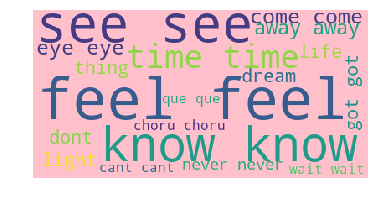

In [116]:
# Ref: https://gist.github.com/tokestermw/3588e6fbbb2f03f89798

# multiplier=1000
def terms_to_wordcounts(terms, multiplier=2000):
    return  " ".join([" ".join(int(multiplier*i[1]) * [i[0]]) for i in terms])

# print([multiplier*(i[1]) for i in terms])
terms = lda_model.show_topic(4, 20)
multiplied_terms = terms_to_wordcounts(terms, 1000)
wordcloud = WordCloud(background_color="pink").generate(multiplied_terms)

# terms = lda_model.show_topic(4, 20)
# multiplied_terms = terms_to_wordcounts(terms, 1000)
# wordcloud2 = WordCloud(background_color="pink").generate(multiplied_terms)

# fig, axs = plt.subplots(1,2)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("terms1")

# plt.close()
